<h1 style="font-size:30px;">Americal Sign Language (ASL) - Dataset Subset</h1>  

The Kaggle ASL data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes.

The original dataset contains 3000 images for each class, which is appropriate for training a model from scratch.

For transfer learning, we only need a few hundred images for each class.  This notebook creates a new directory which contains 200 images for each class.



## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Reducing the Dataset](#2-Reducing-the-Dataset)
* [3 Dataset Overview](#3-Dataset-Oveview)
* [4 Dataset Configuration](#4-Dataset-Configuration)
* [5 Dataset Preparation](#4-Dataset-Preparation)
* [6 Conclusion](#6-Conclusion)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

## 1 System Configuration

In [2]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Reducing the Dataset

In [3]:
dataset_path = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
reduced_dataset_path = './dataset_ASL_reduced'

In [4]:
# Class names.
class_names = sorted([f for f in os.listdir(dataset_path) if not f.startswith('.')])

In [6]:
import os, shutil

if os.path.exists(reduced_dataset_path):
    shutil.rmtree(reduced_dataset_path) 
os.mkdir(reduced_dataset_path)
        
for i in range(len(class_names)):
    
    image_paths = glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True)

    random_idx = random.choice(list(range(0, len(image_paths))))
    image = plt.imread(image_paths[random_idx])
    
    dst_path = reduced_dataset_path + '/' + class_names[i]
    os.mkdir(dst_path)
    print("Processing : ",dst_path)
    
    for j in range(200):
        src_path = image_paths[j]
        shutil.copy(src_path,dst_path)


Processing :  ./dataset_ASL_reduced/A
Processing :  ./dataset_ASL_reduced/B
Processing :  ./dataset_ASL_reduced/C
Processing :  ./dataset_ASL_reduced/D
Processing :  ./dataset_ASL_reduced/E
Processing :  ./dataset_ASL_reduced/F
Processing :  ./dataset_ASL_reduced/G
Processing :  ./dataset_ASL_reduced/H
Processing :  ./dataset_ASL_reduced/I
Processing :  ./dataset_ASL_reduced/J
Processing :  ./dataset_ASL_reduced/K
Processing :  ./dataset_ASL_reduced/L
Processing :  ./dataset_ASL_reduced/M
Processing :  ./dataset_ASL_reduced/N
Processing :  ./dataset_ASL_reduced/O
Processing :  ./dataset_ASL_reduced/P
Processing :  ./dataset_ASL_reduced/Q
Processing :  ./dataset_ASL_reduced/R
Processing :  ./dataset_ASL_reduced/S
Processing :  ./dataset_ASL_reduced/T
Processing :  ./dataset_ASL_reduced/U
Processing :  ./dataset_ASL_reduced/V
Processing :  ./dataset_ASL_reduced/W
Processing :  ./dataset_ASL_reduced/X
Processing :  ./dataset_ASL_reduced/Y
Processing :  ./dataset_ASL_reduced/Z
Processing :

In [8]:
# Create archive of dataset subset

def zipdir(path, ziph):
    # Iterate over all the files and folders in the directory
    for root, dirs, files in os.walk(path):
        for file in files:
            # Get the absolute path of the file
            filepath = os.path.join(root, file)
            # Add the file to the ZIP archive
            ziph.write(filepath, os.path.relpath(filepath, path))

# Name of the ZIP archive
zipname = "dataset_ASL_reduced.zip"
# Directory to be compressed
dirname = "dataset_ASL_reduced"

# Create a ZipFile object to write the archive
with zipfile.ZipFile(zipname, "w", zipfile.ZIP_DEFLATED) as ziph:
    # Compress the directory recursively
    zipdir(dirname, ziph)

print(f"Compressed directory {dirname} to {zipname}")

Compressed directory dataset_ASL_reduced to dataset_ASL_reduced.zip


## 3 Dataset Overview

This section provides an overview of the reduced ASL dataset.

In [10]:
dataset_path = './dataset_ASL_reduced'

### 3.1 Dataset Directory Structure

This section takes a look at how the images and folders are structured. 
This will be of particular importance when using `image_dataset_from_directory()`. 


```
└── dataset_ASL_reduced
    ├── A
    ├── B
    ├── C
    ├── ...
    ├── X
    ├── Y
    ├── Z
    ├── {del}
    ├── {nothing}
    └── {space}
```

In [11]:
# Class names.
class_names = sorted([f for f in os.listdir(dataset_path) if not f.startswith('.')])

for i in range(len(class_names)):
    print(i, class_names[i])

0 A
1 B
2 C
3 D
4 E
5 F
6 G
7 H
8 I
9 J
10 K
11 L
12 M
13 N
14 O
15 P
16 Q
17 R
18 S
19 T
20 U
21 V
22 W
23 X
24 Y
25 Z
26 del
27 nothing
28 space


### 3.2 Display one Image for each Class

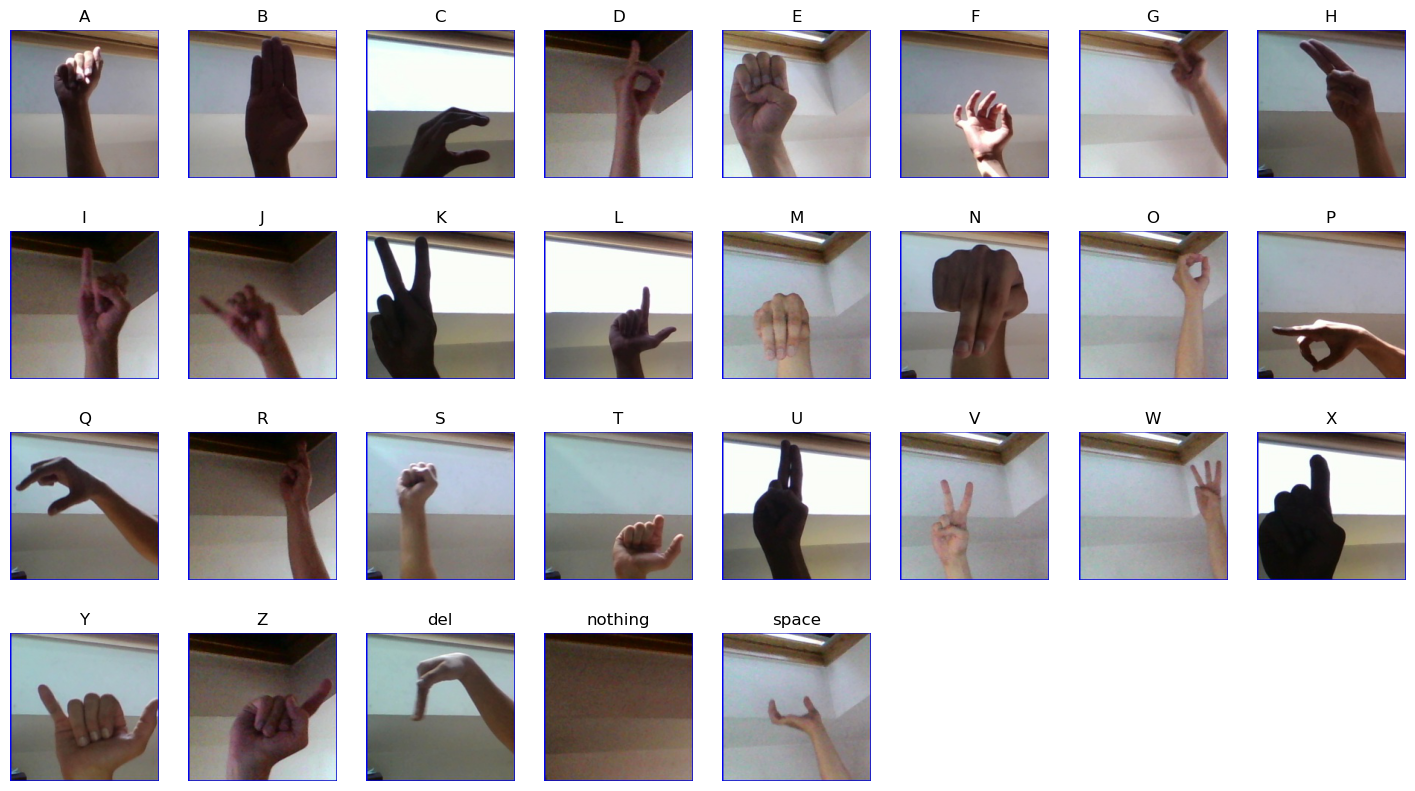

In [12]:
plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

for i in range(len(class_names)):
    
    image_paths = glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True)

    random_idx = random.choice(list(range(0, len(image_paths))))
    image = plt.imread(image_paths[random_idx])
    
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(class_names[i])
    plt.axis("off")


### 3.3 Display Class Histogram

We want to ensure that the dataset is balanced.  A balanced dataset will have the same number of data for each class.

In [14]:
for i in range(len(class_names)):
    
    image_paths = glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True)
    num_images = len(image_paths)

    print(i, class_names[i], num_images)    


0 A 200
1 B 200
2 C 200
3 D 200
4 E 200
5 F 200
6 G 200
7 H 200
8 I 200
9 J 200
10 K 200
11 L 200
12 M 200
13 N 200
14 O 200
15 P 200
16 Q 200
17 R 200
18 S 200
19 T 200
20 U 200
21 V 200
22 W 200
23 X 200
24 Y 200
25 Z 200
26 del 200
27 nothing 200
28 space 200


### 3.4 Visualize Data

We want to visualize the dataset to check for anything unusual.

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)

# Display function
# ================
def view(button):
    display_handle=display(None, display_id=True)

    for i in range(len(class_names)):
    
        image_paths = sorted(glob.glob(f"{dataset_path}/{class_names[i]}/*", recursive=True))

        for j in range(0, len(image_paths)):
            image = plt.imread(image_paths[j])    
    
            _, frame = cv2.imencode('.jpeg',image)
            display_handle.update(Image(data=frame.tobytes()))
                
            if stopButton.value==True:
                cap.release()
                display_handle.update(None)

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

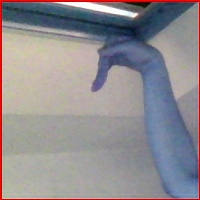

In [24]:
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

## 4 Dataset Configuration

In [10]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 64
    DATA_ROOT:   str = dataset_path

## 5 Dataset Preparation

### 5.1 Prepare the Dataset with `image_dataset_from_directory`

In [12]:
asl_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=32,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                           )


Found 5800 files belonging to 29 classes.


### 5.2 Display Sample Images

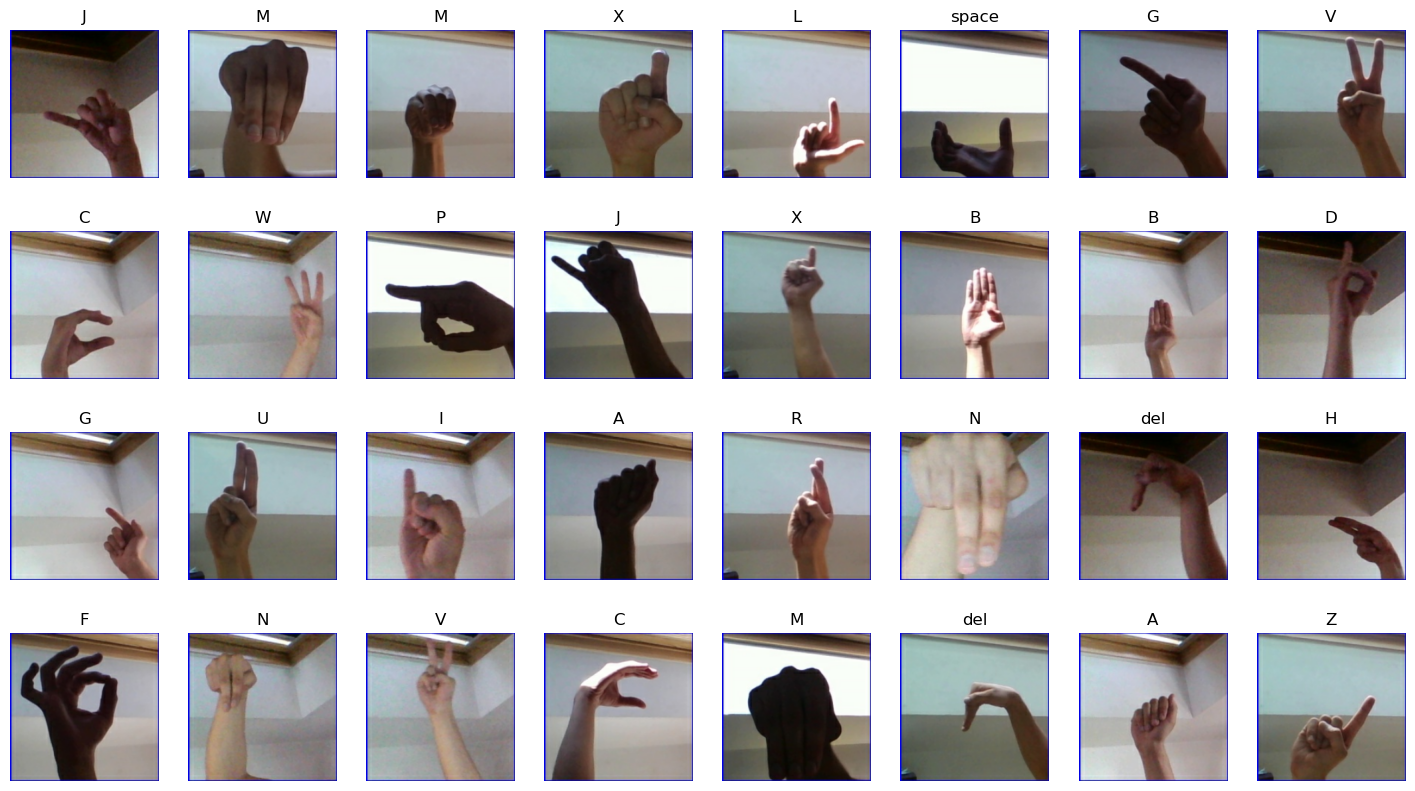

In [13]:
class_names = asl_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in asl_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

## 6 Conclusion

In this notebook, we created a reduced version of the Kaggle ASL Dataset. 